In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
def simulate_brownian_paths(d, M, N, dt, seed=42):
    """
    Simulates Brownian paths given the following input
        - d: number of 2D Brownian paths to be generated, useful if one for instance needs 3 different Brownian motions to be generated at the same time
        - M: number of Monte Carlo simulations, i.e. number of Brownian paths
        - N: number of time steps for a single Brownian Motion
        - seed: default is 42. Sets a seed for reproducibility
    
    and returns
        - dW: either a 2D or 3D matrix with Brownian Motions
    """
    np.random.seed(seed if seed != -1 else None)

    if(d == 0):
        dW = np.sqrt(dt) * np.random.normal(size=(M, N))
        return dW
    else:
        dW = np.sqrt(dt) * np.random.normal(size=(d, M, N))
        return dW

#### *Q4*

In [3]:
#exact solutions to I, sigma and S
def exact_I(I0, a, b, c, T, M, dW_2, N):
    time_arr = np.linspace(0, T, N+1)  
    cumul_sum = np.cumsum(np.exp(b * time_arr[1:])*dW_2[:,1:], axis=1)  #dim=(M,N), approximating the stochastic integral by Riemann sums
    integral_approx = np.hstack([np.zeros((M, 1)), c*np.exp(-b*time_arr[1:])*cumul_sum])  #dim=(M,N+1), adding a column of zeros to achive N+1 columns

    #since I is a matrix, where the deterministic part is constant for all M Monte Carlo sims., every row is equal
    det_part = np.zeros((M,N+1))
    for i in range(M):
        det_part[i] = I0*np.exp(-b*time_arr) + a*(1-np.exp(-b*time_arr))/b

    I = det_part + integral_approx  #dim=(M,N+1)
    return I

def exact_sigma(sigma0, lambda_, f, T, M, dW_3, N):
    time_arr = np.linspace(0, T, N+1)
    cumul_sum = np.cumsum(np.exp(lambda_*time_arr[1:]) * dW_3[:,1:], axis=1) #dim=(M,N), approximating the stochastic integral by Riemann sums
    integral_approx = np.hstack([np.zeros((M, 1)), f*np.exp(-lambda_ * time_arr[1:])*cumul_sum])  #dim=(M,N+1), adding a column of zeros to achive N+1 colum
    
     #since sigma is a matrix, where the deterministic part is constant for all M Monte Carlo sims., every row is equal
    det_part = np.zeros((M,N+1))
    for i in range(M):
        det_part[i] = sigma0*np.exp(-lambda_*time_arr)

    sigma = det_part + integral_approx #dim=(M,N+1)
    return sigma

def exact_S(S0, I0, a, b, c, sigma0, lambda_, f, T, dt, M, dW, N):
    dW_1, dW_2, dW_3 = dW
    
    #adding zero columns to each dW
    dW_1 = np.hstack([np.zeros((M, 1)), dW_1])
    dW_2 = np.hstack([np.zeros((M, 1)), dW_2])
    dW_3 = np.hstack([np.zeros((M, 1)), dW_3])

    I = exact_I(I0, a, b, c, T, M, dW_2, N) #dim=(M,N+1)
    sigma = exact_sigma(sigma0, lambda_, f, T, M, dW_3, N) #dim=(M,N+1)
    
    drift_integral = np.cumsum((I - 0.5*sigma**2)*dt, axis=1)  #dim=(M,N+1)
    stoch_integral_part = np.hstack([np.zeros((M,1)), np.cumsum(sigma[:,1:]*dW_1[:,1:], axis=1)])  #adding a zero column to the cumulative sum matrix, dim=(M,N+1)
    
    S = S0 * np.exp(drift_integral + stoch_integral_part)  
    return S

In [4]:
#numerical approximation of I (stochastic drift), sigma (stochastic diffusion) and S using Euler-Maruyama
def stoch_drift_EM(I_prev, a, b, c, delta_t, dW_2):
    return I_prev + (a - b*I_prev)*delta_t + c*dW_2

def stoch_diffusion_EM(sigma_prev, lambda_, f, delta_t, dW_3):
    return sigma_prev - lambda_*sigma_prev*delta_t + f*dW_3

def euler_maruyama_Q4(S0, I0, a, b, c, sigma0, lambda_, f, T, delta_t, M, dW, N):
    dW_1, dW_2, dW_3 = dW
    S = np.zeros((M, N+1))
    I = np.zeros((M, N+1))
    sigma = np.zeros((M, N+1))
    
    S[:,0] = S0
    I[:,0] = I0
    sigma[:,0] = sigma0

    for i in range(N):
        I[:,i+1] = stoch_drift_EM(I[:,i], a, b, c, delta_t, dW_2[:,i])
        sigma[:,i+1] = stoch_diffusion_EM(sigma[:,i], lambda_, f, delta_t, dW_3[:,i])
        S[:,i+1] = S[:,i] + (I[:,i]*S[:,i])*delta_t + (sigma[:,i]*S[:,i])*dW_1[:,i]  
    return S

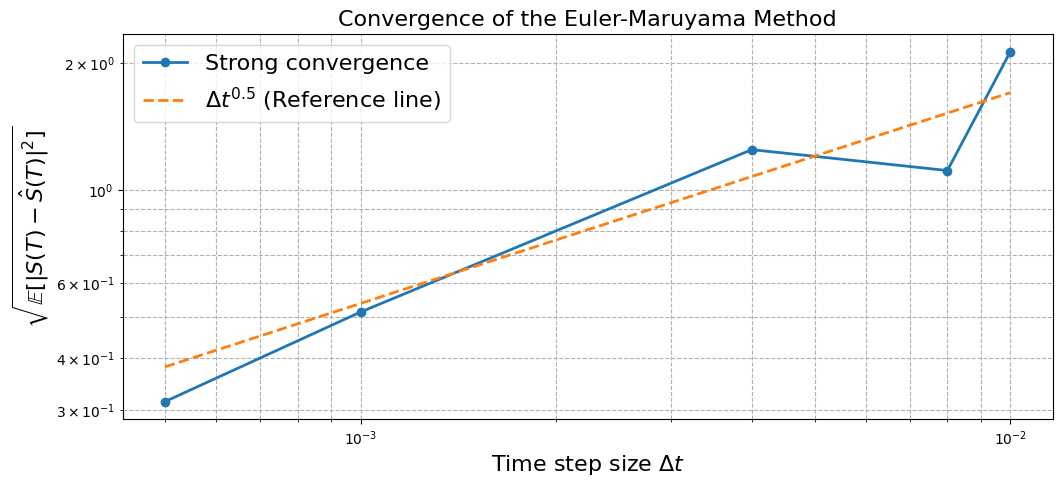

In [5]:
#global variables
a = 0.1
b = 0.5
c = 0.5
lambda_ = 1
f = 1
T = 2.0
dt_fine = 10**-5
M = 100
S0 = 2
I0 = 0.5
sigma0 = 2
delta_ts = np.array([5*10**-4, 10**-3, 4*10**-3, 8*10**-3, 10**-2])

#exact solution and Brownian Motions on a fine grid
N_fine = int(round(T/dt_fine))
dW_fine = simulate_brownian_paths(3, M, N_fine, dt_fine, seed=42)
S_exact = exact_S(S0, I0, a, b, c, sigma0, lambda_, f, T, dt_fine, M, dW_fine, N_fine)

#calculating errors
errors = np.zeros(len(delta_ts))
for i, delta_t in enumerate(delta_ts):
    N_coarse = int(round(T/delta_t))
    ratio = N_fine//N_coarse #need this to ensure we are using the same Brownian motions as for S_exact
    
    dW_coarse = dW_fine.reshape(3, M, N_coarse, ratio).sum(axis=3) #ensuring that we are using the same Brownian Motions for numerical computation
    S_numerical = euler_maruyama_Q4(S0, I0, a, b, c, sigma0, lambda_, f, T, delta_t, M, dW_coarse, N_coarse)
    errors[i] = np.sqrt(np.mean((S_exact[:,-1] - S_numerical[:,-1])**2))

plt.figure(figsize=(12, 5))
plt.loglog(delta_ts, errors, label='Strong convergence', marker='o', linewidth=2)
plt.loglog(delta_ts, 17*delta_ts**0.5, label=r'$\Delta t^{0.5}$ (Reference line)', linestyle='--', linewidth=2) #*17 for moving the reference line up for better visuals
plt.xlabel(r'Time step size $\Delta t$', fontsize=16)
plt.ylabel(r'$\sqrt{\mathbb{E}[|S(T) - \hat{S}(T)|^2]}$', fontsize=16)
plt.title('Convergence of the Euler-Maruyama Method', fontsize=16)
plt.grid(True, which="both", ls="--")
plt.legend(loc=2, fontsize=16)
plt.show()

#### *Q5*

In [6]:
def euler_maruyama_stocks_Q5(S0, I, sigma, delta_t, T, M, dW):
    N = int(T/delta_t)
    time_arr = np.linspace(0, T, N+1)
    S = np.zeros((M, N+1))
    S[:,0] = np.ones(M)*S0

    for i in range(N):
        S[:,i+1] = S[:, i] +I*S[:,i]*delta_t + sigma*S[:,i]*dW[:,i]
    return S, time_arr

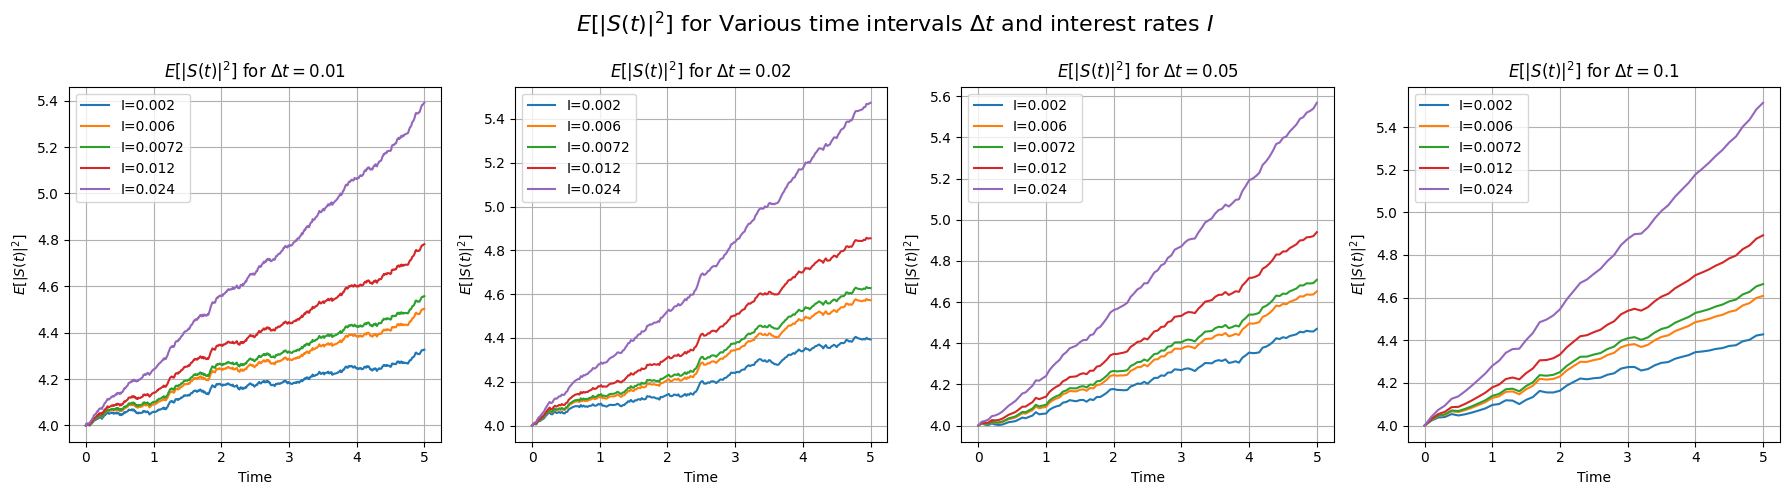

In [7]:
#Part 2
T = 5
S0 = 2
M = 1000
sigma = 0.12
delta_ts = np.array([0.01, 0.02, 0.05, 0.1])
Interest_rates = np.array([0.002, 0.006, 0.0072, 0.012, 0.024])

results = {}
for delta_t in delta_ts:
    N = int(T/delta_t)
    results[delta_t] = {} #to store results and plot them later on

    for I in Interest_rates:
        dW = simulate_brownian_paths(0, M, N, delta_t, seed=42)
        S_numerical, time_arr = euler_maruyama_stocks_Q5(S0, I, sigma, delta_t, T, M, dW)
        mean_square = np.mean(S_numerical**2, axis=0) 
        results[delta_t][I] = (time_arr, mean_square)

#plotting
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
axes = axes.flatten()
for idx, delta_t in enumerate(delta_ts):
    ax = axes[idx]
    for I in Interest_rates:
        times, mean_square = results[delta_t][I]
        ax.plot(times, mean_square, label=f"I={I}")
    
    ax.set_title(rf"$E[|S(t)|^2]$ for $\Delta t = {delta_t}$")
    ax.set_xlabel("Time")
    ax.set_ylabel(r"$E[|S(t)|^2]$")
    ax.legend(loc="upper left")
    ax.grid(True)

fig.suptitle(r"$E[|S(t)|^2]$ for Various time intervals $\Delta t$ and interest rates $I$", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
#Part 3
def stochastic_theta_GBM(S0, I, sigma, delta_t, T, M, dW, theta):
    N = int(T/delta_t)
    time_arr = np.linspace(0, T, N+1)
    S = np.zeros((M, N+1))
    S[:,0] = np.ones(M)*S0

    for i in range(N):
        C1 = 1 - theta*I*delta_t
        C2 = 1 + (1-theta)*I*delta_t + sigma*dW[:,i]
        S[:,i+1] = S[:,i] * (C2/C1)
    return S, time_arr

#global constants for later on
T = 5
S0 = 2
M = 100
sigma = 0.12 #sigma**2/2 = 0.0072

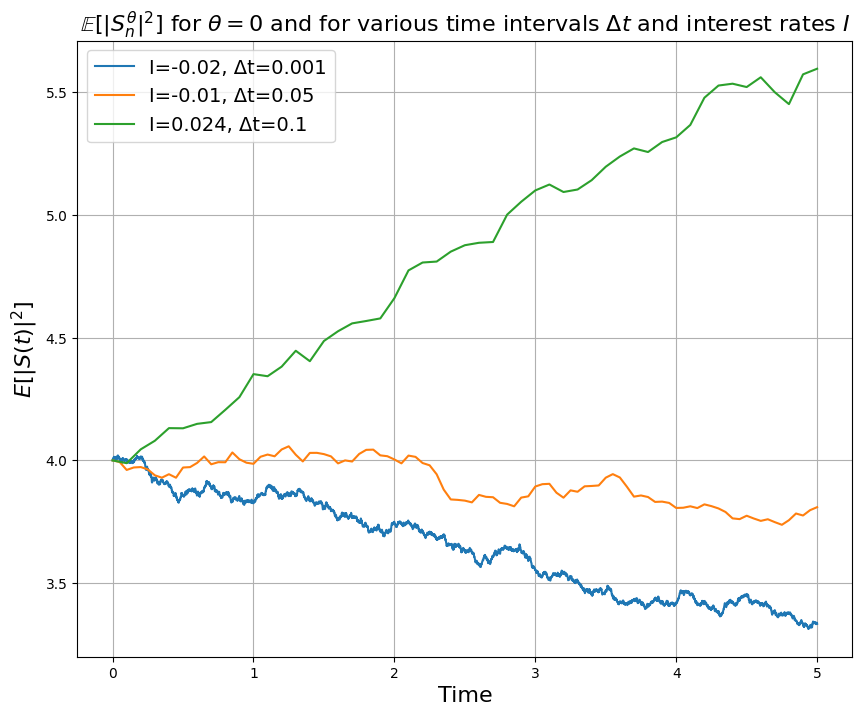

In [9]:
#for theta = 0: need MS. stability for SDE, i.e. I < -sigma^2/2, and another condition: delta_t < - 2*(I+sigma^2/2)/(I^2) to achieve numerical stability
Interest_rates = np.array([-0.02, -0.01, 0.024]) #stable, stable ,unstable
delta_ts = np.array([0.001, 0.05, 0.1]) #stable, stable, unstable

plt.figure(figsize=(10, 8))
for i in range(len(delta_ts)):
    N = int(T/delta_ts[i])
    dW = simulate_brownian_paths(0, M, N, delta_ts[i])
    S_numerical, time_arr = stochastic_theta_GBM(S0, Interest_rates[i], sigma, delta_ts[i], T, M, dW, theta=0)
    mean_square = np.mean(S_numerical**2, axis=0)

    plt.plot(time_arr, mean_square, label=f"I={Interest_rates[i]}, Δt={delta_ts[i]}")

plt.xlabel("Time", fontsize=16)
plt.ylabel(r"$E[|S(t)|^2]$", fontsize=16)
plt.legend(loc="upper left", fontsize=14)
plt.grid(True)
plt.title(r"$\mathbb{E}[|S_n^{\theta}|^2]$ for $\theta=0$ and for various time intervals $\Delta t$ and interest rates $I$", fontsize=16)
plt.show()

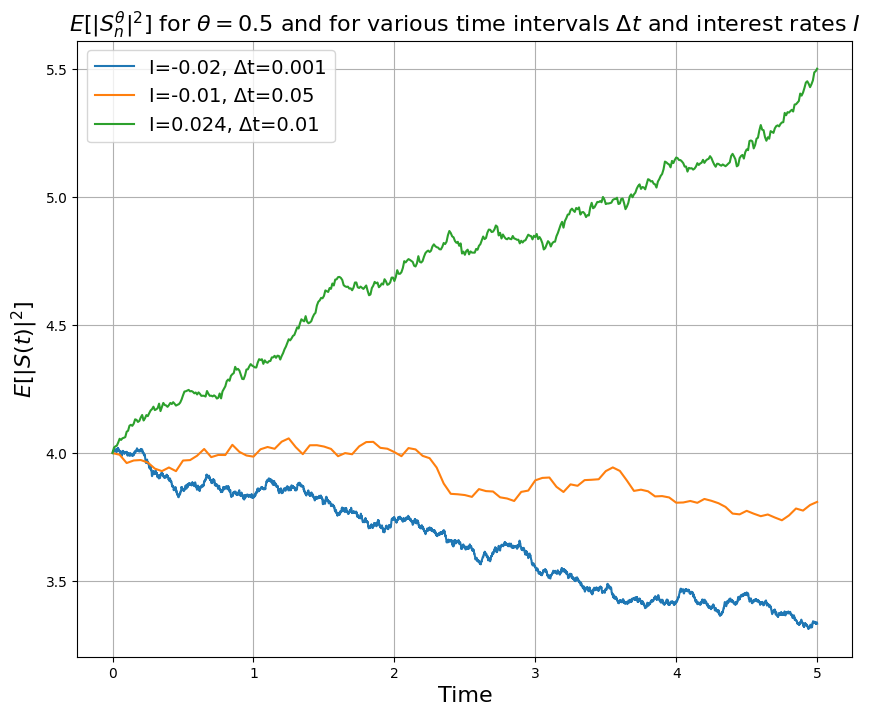

In [10]:
#for theta = 0.5: need MS. stability for SDE, i.e. I < -sigma^2/2, to achieve numerical stability
Interest_rates = np.array([-0.02, -0.01, 0.024]) #stable, stable ,unstable
delta_ts = np.array([0.001, 0.05, 0.01]) #stable, stable ,unstable

plt.figure(figsize=(10, 8))
for i in range(len(delta_ts)):
    N = int(T/delta_ts[i])
    dW = simulate_brownian_paths(0, M, N, delta_ts[i])
    S_numerical, time_arr = stochastic_theta_GBM(S0, Interest_rates[i], sigma, delta_ts[i], T, M, dW, theta=0.5)
    mean_square = np.mean(S_numerical**2, axis=0)

    plt.plot(time_arr, mean_square, label=f"I={Interest_rates[i]}, Δt={delta_ts[i]}")

plt.xlabel("Time", fontsize=16)
plt.ylabel(r"$E[|S(t)|^2]$", fontsize=16)
plt.legend(loc="upper left", fontsize=14)
plt.grid(True)
plt.title(r"$E[|S_n^{\theta}|^2]$ for $\theta=0.5$ and for various time intervals $\Delta t$ and interest rates $I$", fontsize=16)
plt.show()

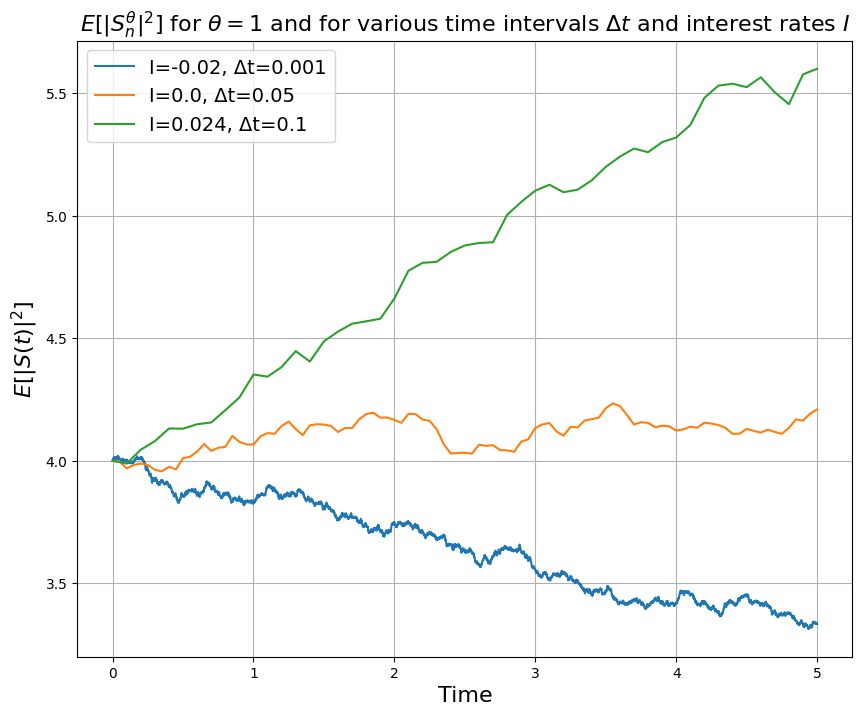

In [11]:
# for theta = 1: need MS. stability for SDE, i.e. I < -sigma^2/2, to achieve numerical stability OR delta_t > 2I + sigma^2 is SDE is MS. unstable
Interest_rates = np.array([-0.02, 0.0, 0.024]) #stable, stable ,unstable
delta_ts = np.array([0.001, 0.05, 0.1]) #stable, stable ,unstable

plt.figure(figsize=(10, 8))
for i in range(len(delta_ts)):
    N = int(T/delta_ts[i])
    dW = simulate_brownian_paths(0, M, N, delta_ts[i])
    S_numerical, time_arr = stochastic_theta_GBM(S0, Interest_rates[i], sigma, delta_ts[i], T, M, dW, theta=1)
    mean_square = np.mean(S_numerical**2, axis=0)

    plt.plot(time_arr, mean_square, label=f"I={Interest_rates[i]}, Δt={delta_ts[i]}")

plt.xlabel("Time", fontsize=16)
plt.ylabel(r"$E[|S(t)|^2]$", fontsize=16)
plt.legend(loc="upper left", fontsize=14)
plt.grid(True)
plt.title(r"$E[|S_n^{\theta}|^2]$ for $\theta=1$ and for various time intervals $\Delta t$ and interest rates $I$", fontsize=16)
plt.show()

In [12]:
#Part 4: Using function stoch_diffusion_EM from Q4-4
#Euler-Maruyama scheme
def euler_maruyama_diffusion_Q5(sigma0, lambda_, f, delta_t, T, M, dW):
    N = int(T/delta_t)
    time_arr = np.linspace(0, T, N+1)
    sigma = np.zeros((M, N+1))
    sigma[:,0] = np.ones(M)*sigma0
    
    for i in range(N):
        sigma[:,i+1] = stoch_diffusion_EM(sigma[:,i], lambda_, f, delta_t, dW[:,i])
    return sigma, time_arr

Maximum allowed value for Δt: 12.357588823428845


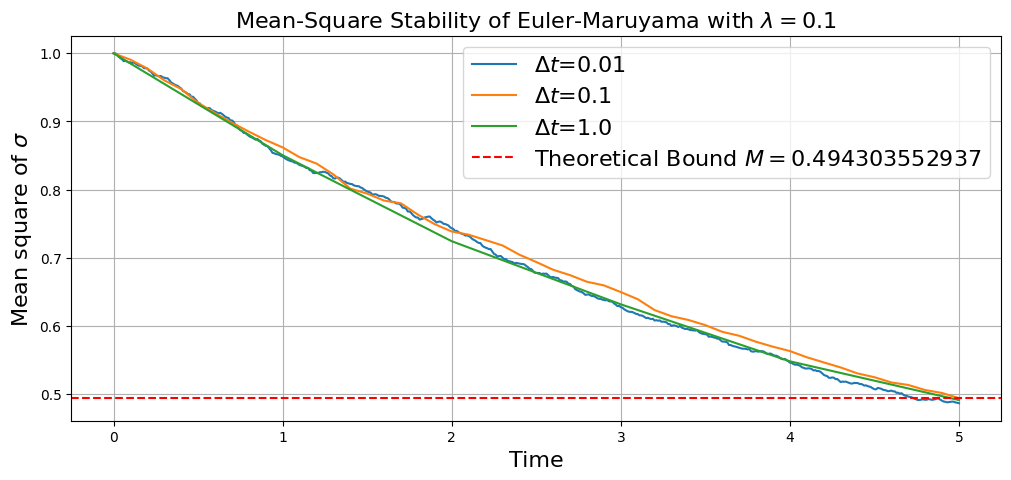

In [13]:
M = 1000
f = 0.2
lambda_ = 0.1
T = 5
sigma0 = 1

upper_bound = (sigma0**2 - f**2/(2*lambda_)) * np.exp(-2*lambda_*T) + f**2/(2*lambda_)
delta_t_bound = upper_bound/f**2
print(f"Maximum allowed value for Δt: {delta_t_bound}")

delta_ts = np.array([0.01, 0.1, 1])

plt.figure(figsize=(12, 5))
for delta_t in delta_ts:
    N = int(T/delta_t)
    dW = simulate_brownian_paths(0, M, N, delta_t)
    sigma, time_arr = euler_maruyama_diffusion_Q5(sigma0, lambda_, f, delta_t, T, M, dW)
    mean_square = np.mean(sigma**2, axis=0)
    plt.plot(time_arr, mean_square, label=rf"$\Delta t$={delta_t}")

plt.axhline(y=upper_bound, color="r", linestyle="--", label=rf"Theoretical Bound $M=${round(upper_bound, 12)}")
plt.xlabel("Time", fontsize=16)
plt.ylabel(r"Mean square of $\sigma$", fontsize=16)
plt.title(rf"Mean-Square Stability of Euler-Maruyama with $\lambda=${lambda_}", fontsize=16)
plt.legend(loc=1, fontsize=16)
plt.grid(True)
plt.show()

Maximum allowed value for Δt: 0.1


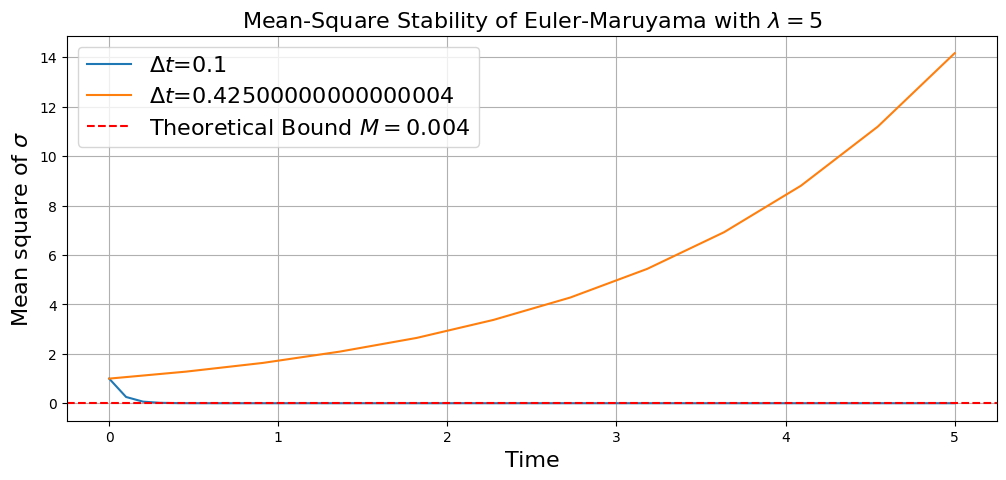

In [14]:
#Unstable condition
M = 1000
f = 0.2
lambda_ = 5 #this values was changed from 0.1 to 5!
T = 5
sigma0 = 1

upper_bound = (sigma0**2 - f**2/(2*lambda_)) * np.exp(-2*lambda_*T) + f**2/(2*lambda_)
delta_t_bound = upper_bound/f**2
print(f"Maximum allowed value for Δt: {delta_t_bound}")

delta_ts = np.array([delta_t_bound, delta_t_bound + 0.325])

plt.figure(figsize=(12, 5))
for delta_t in delta_ts:
    N = int(T/delta_t)
    dW = simulate_brownian_paths(0, M, N, delta_t)
    sigma, time_arr = euler_maruyama_diffusion_Q5(sigma0, lambda_, f, delta_t, T, M, dW)
    mean_square = np.mean(sigma**2, axis=0)
    plt.plot(time_arr, mean_square, label=rf"$\Delta t$={delta_t}")

plt.axhline(y=upper_bound, color="r", linestyle="--", label=rf"Theoretical Bound $M=${round(upper_bound, 12)}")
plt.xlabel("Time", fontsize=16)
plt.ylabel(r"Mean square of $\sigma$", fontsize=16)
plt.title(rf"Mean-Square Stability of Euler-Maruyama with $\lambda=${lambda_}", fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.grid(True)
plt.show()

#### *Q6*

In [15]:
def analytical_solution_G_Q6(S0, drift, sigma, K, time_arr):
    N = len(S0)
    KKT = K@K.T
    S0_outer = np.outer(S0, S0)
    results = np.zeros((len(time_arr), N, N))

    for i, t in enumerate(time_arr):
        A = 2*(drift - 0.5*sigma**2*KKT)*t + 2*sigma**2*t*KKT
        results[i] = S0_outer@sp.linalg.expm(A) 
    return np.array(results)

def euler_maruyama_Q6(S0, drift, diffusion, delta_t, T, d, M, dW):
    N = int(T/delta_t)
    S = np.zeros((M, d, N+1))
    S[:,:,0] = np.ones((M, 1))*S0
    time_arr = np.linspace(0, T, N+1)

    for n in range(N):
        for m in range(M):
            S[m,:,n+1] = S[m,:,n] + drift@S[m,:,n]*delta_t + diffusion@S[m,:,n]*dW[:,m,n]
    return S, time_arr

def monte_carlo_expectation(S_numerical, delta_t, T, M, d):
    N = int(T/delta_t)
    expectations = np.zeros((N+1, d, d))

    for n in range(N+1):
        expectations[n] = np.mean([np.outer(S_numerical[m, :, n], S_numerical[m, :, n]) for m in range(M)], axis=0)
    return expectations

def error_func(S_numerical, G_t, delta_t, T, M, d):
    N = int(T/delta_t)
    expectations = monte_carlo_expectation(S_numerical, delta_t, T, M, d)    
    norm_n = np.array([np.linalg.norm(expectations[n] - G_t[n], ord='fro')**2 for n in range(N+1)])
    error = np.sqrt(np.sum(norm_n)*delta_t)
    return error

In [16]:
d = 5
T = 1
I = 0.01
sigma = 0.001

M_vals = np.array([100, 2000])
delta_ts = np.sort(np.array([0.1, 0.05, 0.01, 0.001]))

np.random.seed(29) #seed for R matrix
R = np.random.uniform(low=0.0, high=1.0, size=(d,d))
K = R@R.T
drift = I*np.identity(d)
diffusion = sigma*K

S0 = np.array([2, 1.75, 1.5, 10, 15])*5
errors = np.zeros((len(M_vals), len(delta_ts)))

for i in range(len(delta_ts)):
    for j in range(len(M_vals)):
        N = int(T/delta_ts[i])
        dW = simulate_brownian_paths(d, M_vals[j], N, delta_ts[i])
        S_numerical, time_arr = euler_maruyama_Q6(S0, drift, diffusion, delta_ts[i], T, d, M_vals[j], dW)
        G_t = analytical_solution_G_Q6(S0, drift, sigma, K, time_arr)
        errors[j,i] = error_func(S_numerical, G_t, delta_ts[i], T, M_vals[j], d)

print(errors)

[[5.7168332  7.21579557 4.87287343 8.72194196]
 [1.09123596 2.3841979  1.36048305 1.23990388]]


#### *Q7*

In [17]:
def lamperti_euler_Q7(v0, eta, k, mu, M, dt, dW, N):
    Y = np.sqrt(v0) * np.ones((M, N + 1))
    for n in range(N):
        drift = (k*(mu - Y[:,n]**2)/(2*Y[:,n])) - (eta**2/(8*Y[:,n]))
        Y[:,n+1] = Y[:,n] + drift*dt + (eta/2)*dW[:,n]
    return Y**2

#stochastic theta method for theta=1
def stoch_theta_Q7(v0, eta, k, mu, M, dt, dW, N):
    v = v0 * np.ones((M, N + 1))
    for n in range(N):
        v[:, n+1] = (v[:, n] + k*mu*dt + eta*np.sqrt(np.maximum(v[:, n],0))*dW[:, n])/(1 + k*dt)
    return v

#true solution using numerical Lamperti-Euler method with very fine grid
def true_sol_Q7(v0, eta, k, mu, M, dt_fine, dW_fine, N_fine):
    return lamperti_euler_Q7(v0, eta, k, mu, M, dt_fine, dW_fine, N_fine)

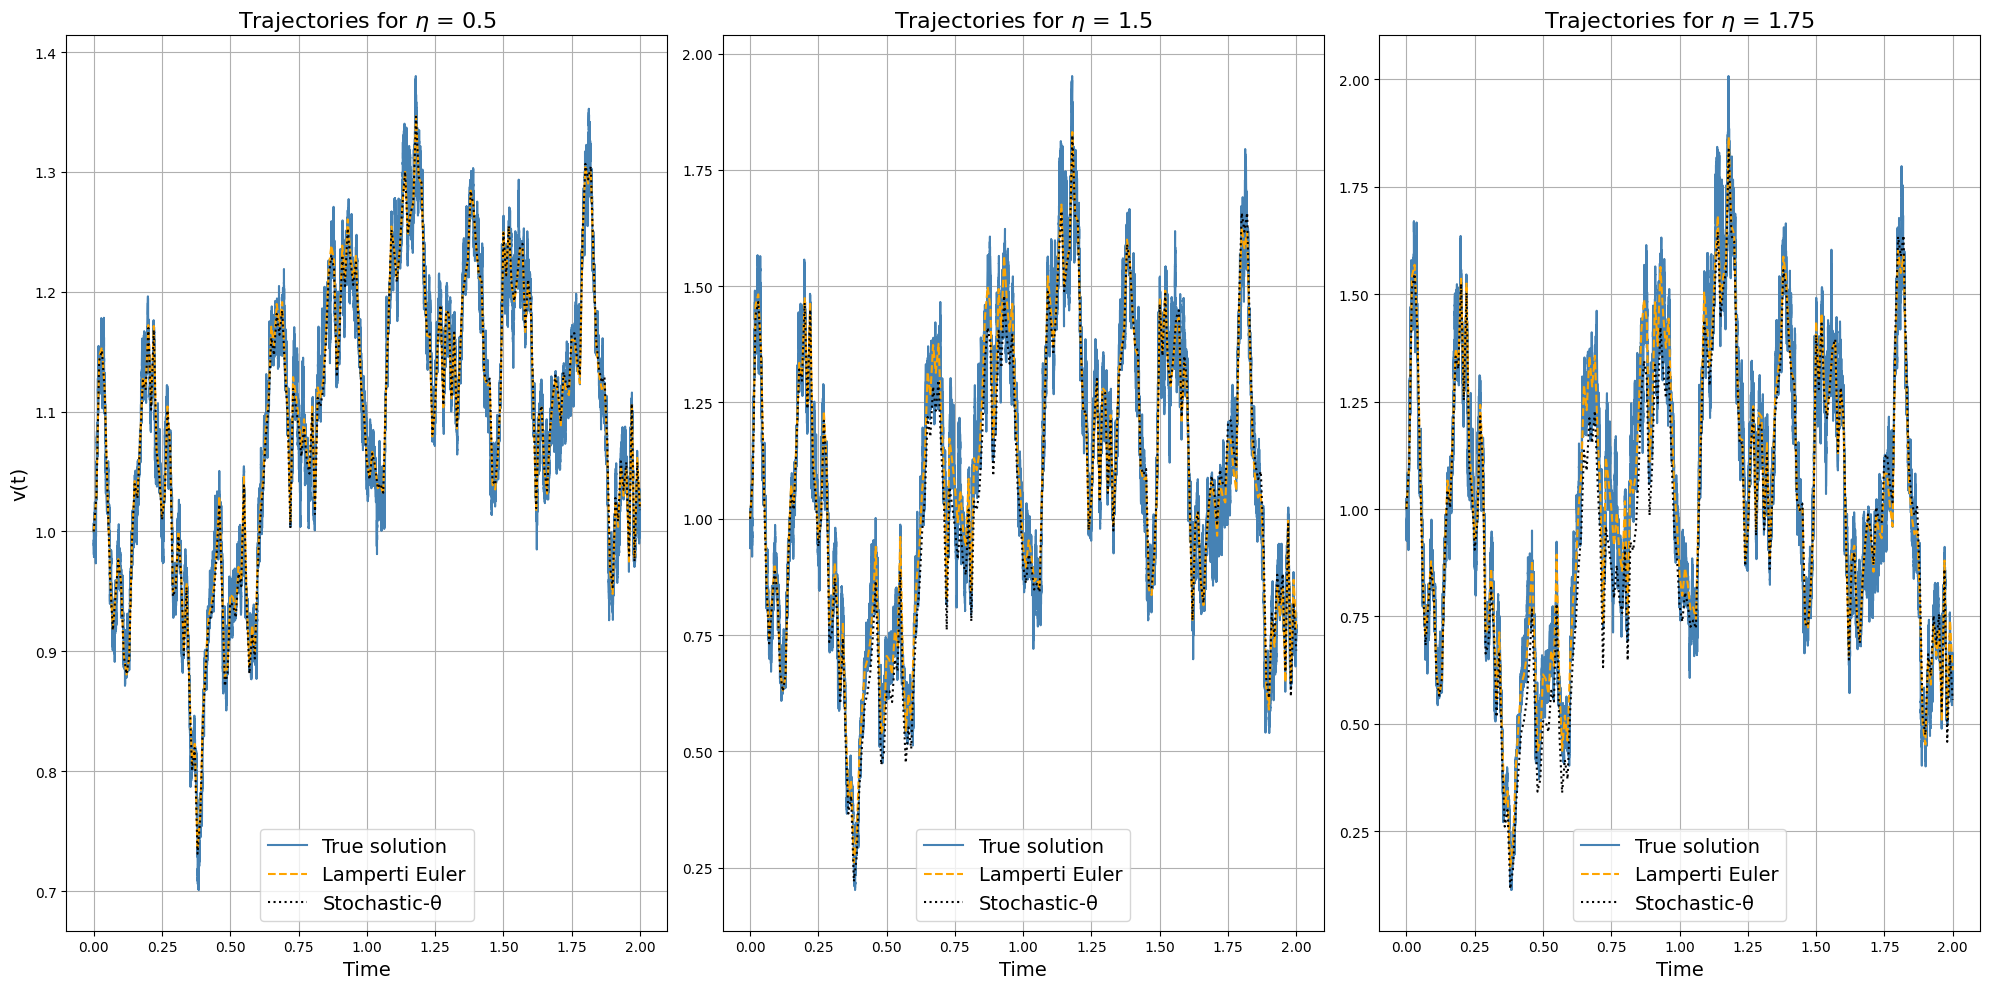

L^2 errors for Lamperti-Euler and Stochastic-θ methods:
η = 0.5: Lamperti Euler = 0.0015615572688598145, Stochastic-θ = 0.006447139083260023
η = 1.5: Lamperti Euler = 369.3266387013498, Stochastic-θ = 0.3060077371610963
η = 1.75: Lamperti Euler = 8.882716997427773, Stochastic-θ = 1.7155822435312353


In [22]:
#global constants
k = 1
mu = 1
v0 = 1
T = 2.0  
M = 500
dt_fine = 10**-5
dt_coarse = 10**-2
eta_vals = [0.5, 1.5, 1.75]

N_fine = int(round(T/dt_fine))
N_coarse = int(round(T/dt_coarse))
ratio = N_fine//N_coarse #need this to use the same realisations of Brownian Motions

t_fine = np.linspace(0, T, N_fine + 1)
t_coarse = np.linspace(0, T, N_coarse + 1)

#generating Brownian motions
dW_fine = simulate_brownian_paths(0, M, N_fine, dt_fine)

#reshaping fine grid to more coarse grid
dW_fine_reshaped = dW_fine.reshape(M, N_coarse, ratio)
dW_coarse = dW_fine_reshaped.sum(axis=2)

#computing errors and plotting
fig, ax = plt.subplots(1, len(eta_vals), figsize=(20, 10))
errors = {}
for i in range(len(eta_vals)):
    #exact solution
    v_true = true_sol_Q7(v0, eta_vals[i], k, mu, M, dt_fine, dW_fine, N_fine)
    
    #Euler-Lamperti and stochastic theta approx. 
    v_lamp = lamperti_euler_Q7(v0, eta_vals[i], k, mu, M, dt_coarse, dW_coarse, N_coarse)
    v_theta = stoch_theta_Q7(v0, eta_vals[i], k, mu, M, dt_coarse, dW_coarse, N_coarse)

   #L2-errors
    error_lamp = np.sqrt(np.mean((v_true[:, -1] - v_lamp[:, -1])**2))
    error_theta = np.sqrt(np.mean((v_true[:, -1] - v_theta[:, -1])**2))
    errors[eta_vals[i]] = (error_lamp, error_theta)

    #plotting
    ax[i].plot(t_fine, v_true[0, :], label="True solution", color='steelblue')
    ax[i].plot(t_coarse, v_lamp[0, :], label="Lamperti Euler", linestyle='--', color='orange')
    ax[i].plot(t_coarse, v_theta[0, :], label="Stochastic-θ", linestyle=':', color='black')
    ax[i].set_title(rf"Trajectories for $\eta$ = {eta_vals[i]}", fontsize=16)
    ax[i].set_xlabel("Time", fontsize=14)
    if i == 0:
        ax[i].set_ylabel("v(t)", fontsize=14)
    ax[i].grid(True)
    ax[i].legend(loc=8, fontsize=14)
plt.tight_layout()
plt.show()

#errors in L^2
print("L^2 errors for Lamperti-Euler and Stochastic-θ methods:")
for eta, (error_lamp, error_theta) in errors.items():
    print(f"η = {eta}: Lamperti Euler = {error_lamp}, Stochastic-θ = {error_theta}")

#### *Q8*

In [19]:
#call option pricing model given in the project paper
def Black_Scholes(s, K, r, sigma, t, T):
    tau = T - t
    x1 = (np.log(s/K) + (r+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    x2 = x1 - sigma * np.sqrt(tau)
    return s * norm.cdf(x1) - K * np.exp(-r*tau) * norm.cdf(x2)

def payoff(S, K):
    return np.maximum(S-K,0)

def euler_maruyama_Q8(S0, r, sigma, delta_t, T, M, dW):
    N = int(T/delta_t)
    S = np.zeros((M, N+1)) 
    S[:,0] = np.ones(M)*S0

    for n in range(N):
        S[:,n+1] = S[:,n] + r*S[:,n]*delta_t + sigma*S[:,n]*dW[:,n]
    return S

In [20]:
S0 = 8
K = 10
r = 0.05
sigma = 0.5
dt = 0.001
t = 0
T = 1
d = 1
M = 100

dW = simulate_brownian_paths(0, M, int(T/dt), dt)
S_numerical = euler_maruyama_Q8(S0, r, sigma, dt, T, M, dW)
C_numerical = np.exp(-r * T) * np.mean(payoff(S_numerical[:, -1], K))
C_analytical = Black_Scholes(S0, K, r, sigma, t, T)

print(f"Analytical Price: {C_analytical:.4f}")
print(f"Numerical Price: {C_numerical:.4f}")
print(f"Absolute error: {np.abs(C_numerical-C_analytical):.4f}")

Analytical Price: 1.0726
Numerical Price: 1.1402
Absolute error: 0.0676


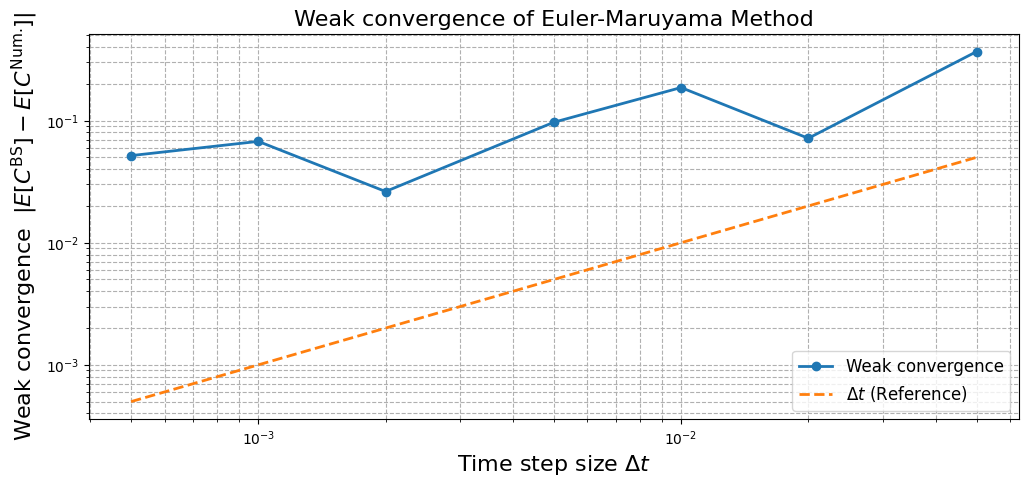

In [21]:
errors = []
delta_ts = np.array([0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05])
for dt in delta_ts:
    dW = simulate_brownian_paths(0, M, int(T/dt), dt)
    S_numerical = euler_maruyama_Q8(S0, r, sigma, dt, T, M, dW)
    C_numerical = np.exp(-r * T) * np.mean(payoff(S_numerical[:, -1], K))
    error = abs(C_analytical - C_numerical)
    errors.append(error)

plt.figure(figsize=(12, 5))
plt.loglog(delta_ts, errors, label='Weak convergence', marker='o', linewidth=2)
plt.loglog(delta_ts, delta_ts, label=r'$\Delta t$ (Reference)', linestyle='--', linewidth=2)
plt.xlabel(r'Time step size $\Delta t$', fontsize = 16)
plt.ylabel(r"Weak convergence  $|E[C^{\text{BS}}] - E[C^{\text{Num.}}]|$", fontsize = 16)
plt.title('Weak convergence of Euler-Maruyama Method', fontsize = 16)
plt.grid(True, which="both", ls="--")
plt.legend(loc=4, fontsize = 12)
plt.show()